In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import HomeMade as hm
import importlib
hm = importlib.reload(hm)

In [7]:
N = 2e6

all_features = ['eventCounter',
 'npv',
 'ntrk_pv0',
 'pv0_x',
 'pv0_y',
 'pv0_z',
 'a0xy',
 'a0',
 'a0z',
 'cosTheta',
 'v0_chi2',
 'v0_x',
 'v0_y',
 'v0_z',
 'v0_rxy',
 'v0_rxyErr',
 'v0_px',
 'v0_py',
 'v0_pz',
 'v0_pt',
 'v0_p',
 'v0_ptErr',
 'v0_ks_mass',
 'v0_la_mass',
 'v0_lb_mass',
 'v0_ks_massErr',
 'v0_la_massErr',
 'v0_lb_massErr',
 'v0_px1',
 'v0_py1',
 'v0_pz1',
 'v0_pt1',
 'v0_p1',
 'v0_px2',
 'v0_py2',
 'v0_pz2',
 'v0_pt2',
 'v0_p2',
 'v0_phi1',
 'v0_theta1',
 'v0_qOverP1',
 'v0_phi2',
 'v0_theta2',
 'v0_qOverP2',
 'alpha',
 'calpha',
 'epsilon1',
 'epsilon2',
 'Alpha',
 'pL1',
 'pL2',
 'pT',
 'thetastar',
 'rapidity_ks',
 'rapidity_la',
 'rapidity_lb',
 'pseudorapidity',]

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(all_features + ['trueKs'], entrystop = N)

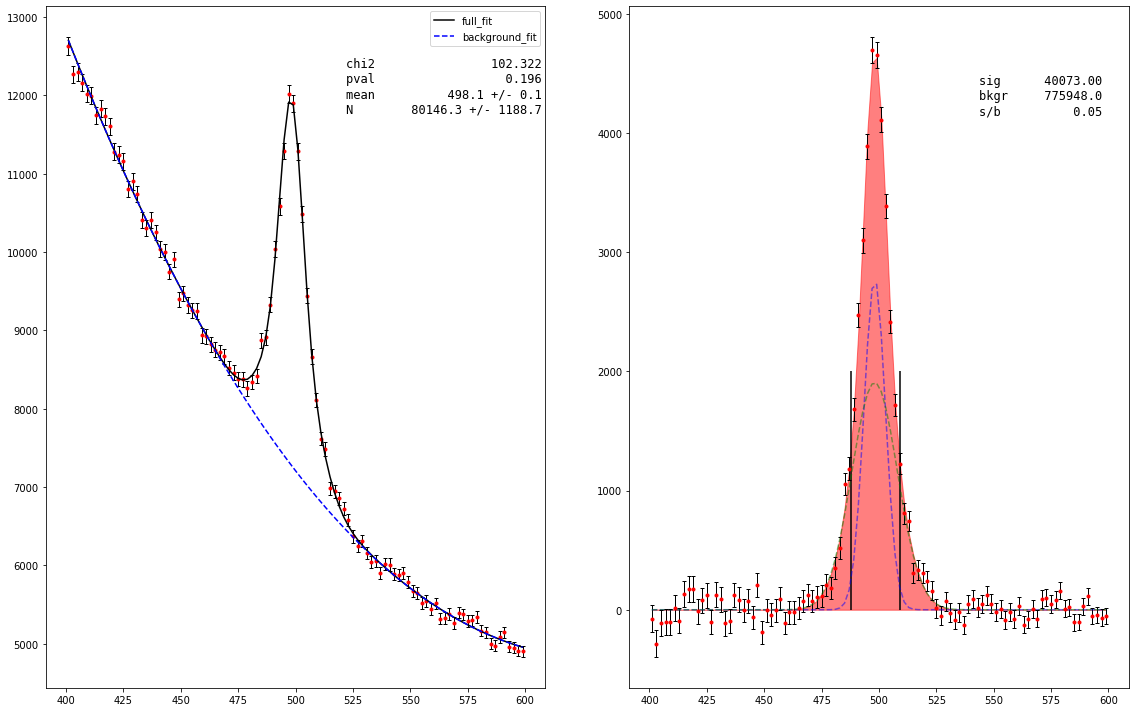

In [8]:
#Create pseudo background and signal from data
signal_range = (488,509)
side_band_l = (400,450)
side_band_r = (550,600)

def mask(array,lims):
    return (array>lims[0])&(array<lims[1])

def hist(array,bins,bin_range):
    vals, binedges = np.histogram(array,bins=bins,range=bin_range)
    return vals, 0.5*(binedges[:-1]+binedges[1:])

vals, binedges = np.histogram(data.v0_ks_mass.loc[(data.v0_ks_mass>400)&(data.v0_ks_mass<600)],bins=100)
binc = 0.5*(binedges[:-1] + binedges[1:])

D = hm.fit_mass2(binc,vals,np.sqrt(vals))

# D['ax'][0].fill_between(binc[mask(binc,signal_range)],vals[mask(binc,signal_range)],min(vals))
D['ax'][0].vlines(signal_range,5000,13000)
D['ax'][0].vlines(side_band_l,5000,13000)
D['ax'][0].vlines(side_band_l,5000,13000)

In [56]:
signal_range = (binedges[np.argmin(abs(binedges-signal_range[0]))],binedges[np.argmin(abs(binedges-signal_range[1]))])
side_band_r = (binedges[np.argmin(abs(binedges-side_band_r[0]))],binedges[np.argmin(abs(binedges-side_band_r[1]))])
side_band_l = (binedges[np.argmin(abs(binedges-side_band_l[0]))],binedges[np.argmin(abs(binedges-side_band_l[1]))])

In [57]:
N = int(D['sig_func'](binc[mask(binc,signal_range)]).sum()+D['bkgr_func'](binc[mask(binc,signal_range)]).sum())
N_bkgr = int(D['bkgr_func'](binc[mask(binc,signal_range)]).sum())
print("Sample Size;", N,"or",sum(mask(data.v0_ks_mass,signal_range)), "background size;", N_bkgr)
N = sum(mask(data.v0_ks_mass,signal_range)) - N_bkgr


Sample Size; 113135 or 113138 background size; 79782


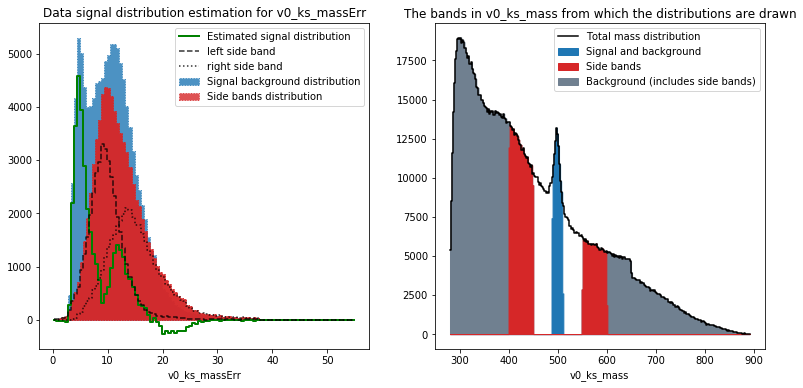

In [92]:
def compare_distribution(mc, data, feature, bins = 100, particle_type = 'Ks',axes=None,alpha=1):
    if not axes:
        fig, axes = plt.subplots(figsize=(13,6),ncols=2)
        ax = axes[0]
        axm = axes[1]
    else:
        ax = axes[0]
        axm = axes[1]
#     ax.set_yscale('log')
    
    q = (0.01,0.99)
    mc = mc[mask(mc[feature],np.quantile(mc[feature],q=q))]
    data = data[mask(data[feature],np.quantile(data[feature],q=q))]
    
    N = sum(mask(data.v0_ks_mass,signal_range)) - N_bkgr
    
    if isinstance(feature,str):
        feat_mc = mc[feature]
        feat_data = data[feature]
    elif isinstance(feature,dict):
        feat_mc = feature['mc']
        feat_data = feature['data']
    else:
        print("Error with 'feature'")
        return
    
    bin_range = (min(feat_mc.min(),feat_data.min()),max(feat_mc.max(),feat_data.max()))

    data_sig_band = feat_data[mask(data.v0_ks_mass,signal_range)].sample(N+N_bkgr)
    sbr = feat_data[mask(data.v0_ks_mass,side_band_r)].sample(N_bkgr//2)
    sbl = feat_data[mask(data.v0_ks_mass,side_band_l)].sample(N_bkgr//2)
    data_side_band = pd.concat([sbr,sbl])
    data_bkgr = feat_data[(data.v0_ks_mass > side_band_r[0])|(data.v0_ks_mass < side_band_l[1])].sample(N)
    
    data_sig_band_vals, data_sig_band_binc = hist(data_sig_band,bins=bins,bin_range=bin_range)
    data_side_band_vals, data_side_band_binc = hist(data_side_band,bins=bins,bin_range=bin_range)
    sbr_vals, sbr_binc = hist(sbr,bins=bins,bin_range=bin_range)
    sbl_vals, sbl_binc = hist(sbl,bins=bins,bin_range=bin_range)
    
    data_sig_vals, data_sig_binc = data_sig_band_vals - data_side_band_vals, data_sig_band_binc
    
    data_bkgr_vals, data_bkgr_binc = hist(data_bkgr,bins=bins,bin_range=bin_range)
    data_vals, data_binc = hist(pd.concat([data_sig_band,data_side_band,data_bkgr]),bins=bins,bin_range=bin_range)
    
#     ax.step(data_sig_binc,data_sig_vals,c='g',ls='dashed',where='mid',alpha=1,label='Data signal')#,ls='dotted',alpha=0.5)
    ax.step(data_sig_band_binc,data_sig_band_vals - sbr_vals - sbl_vals,c='g',where='mid',alpha=1,label='Estimated signal distribution',linewidth=2)
#     ax.step(data_bkgr_binc,data_bkgr_vals,'r.',alpha=alpha,label='Data background')#,ls='dotted',alpha=0.5)
#     ax.step(data_sig_binc,data_sig_vals + data_bkgr_vals,ls='dotted',c='grey',where='mid',label='data')
#     ax.step(data_binc,data_vals,ls='dotted',c='grey',where='mid',label='data')

#     ax.step(data_sig_band_binc,data_sig_band_vals,ls='dotted',c='grey',where='mid',label='data')
    ax.fill_between(data_sig_band_binc,data_sig_band_vals,ls='dotted',color='tab:blue',step='mid',alpha=alpha,label='Signal background distribution')
    
#     ax.step(data_side_band_binc,data_side_band_vals,ls='dotted',c='grey',where='mid',label='data')
    ax.fill_between(data_side_band_binc,data_side_band_vals,ls='dotted',color='tab:red',step='mid',alpha=alpha,label='Side bands distribution')
    
    ax.fill_between(sbr_binc,sbr_vals+sbl_vals,ls='dotted',color='tab:red',step='mid',alpha=alpha)
    ax.step(sbl_binc,sbl_vals,ls='dashed',color='k',where='mid',alpha=alpha,label='left side band')
    ax.step(sbr_binc,sbr_vals,ls='dotted',color='k',where='mid',alpha=alpha,label='right side band')
    
    m = 'v0_ks_mass'
    mass_sig_band = data[m][mask(data.v0_ks_mass,signal_range)]#.sample(N+N_bkgr)
    mass_side_band = pd.concat([data[m][mask(data.v0_ks_mass,side_band_r)],data[m][mask(data.v0_ks_mass,side_band_l)]])
#     mass_side_band = pd.concat([data[m][mask(data.v0_ks_mass,side_band_r)].sample(N_bkgr//2),data[m][mask(data.v0_ks_mass,side_band_l)].sample(N_bkgr//2)])
    mass_bkgr = data[m][(data.v0_ks_mass > side_band_r[0])|(data.v0_ks_mass < side_band_l[1])]#.sample(N)
    
                            
    m_bin_range = (min(mass_bkgr),max(mass_bkgr))
    
    bins = int(2.8*bins)
    mass_sig_vals, mass_sig_binc = hist(mass_sig_band,bins=bins,bin_range=m_bin_range)
    mass_side_vals, mass_side_binc = hist(mass_side_band,bins=bins,bin_range=m_bin_range)
    mass_bkgr_vals, mass_bkgr_binc = hist(mass_bkgr,bins=bins,bin_range=m_bin_range)
    mass_vals, mass_binc = hist(data[m],bins=bins,bin_range=m_bin_range)
    
    axm.fill_between(mass_sig_binc,mass_sig_vals,step='mid',color='tab:blue',label='Signal and background')
    axm.fill_between(mass_side_binc,mass_side_vals,step='mid',color='tab:red',label='Side bands',alpha=1)
    axm.fill_between(mass_bkgr_binc,mass_bkgr_vals,step='mid',color='slategrey',label='Background (includes side bands)',zorder=-1)
    axm.step(mass_binc,mass_vals,where='mid',color='k',label='Total mass distribution')
#     axm.hist(data[m],bins=bins,range=m_bin_range,zorder=-1)

    ax.set(title=f'Data signal distribution estimation for {feature}',
          xlabel=f'{feature}')
    axm.set(title='The bands in v0_ks_mass from which the distributions are drawn',
           xlabel='v0_ks_mass')
    
    axm.legend()
    ax.legend()
    return fig
    
    
fig = compare_distribution(mc,data,'v0_ks_massErr',bins=100,alpha=0.8)

In [87]:
fig.tight_layout()
fig
# fig.savefig('figures/Signal_distribution_in_data_pseudorapidity.pdf')

C:\Users\jv97\anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\jv97\anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jv97\anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\jv97\anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater_equal


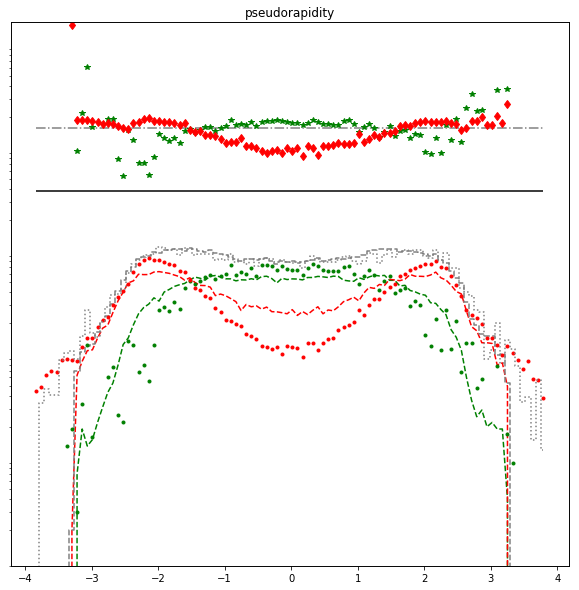

In [24]:
plot_distribution(mc,data,'pseudorapidity')

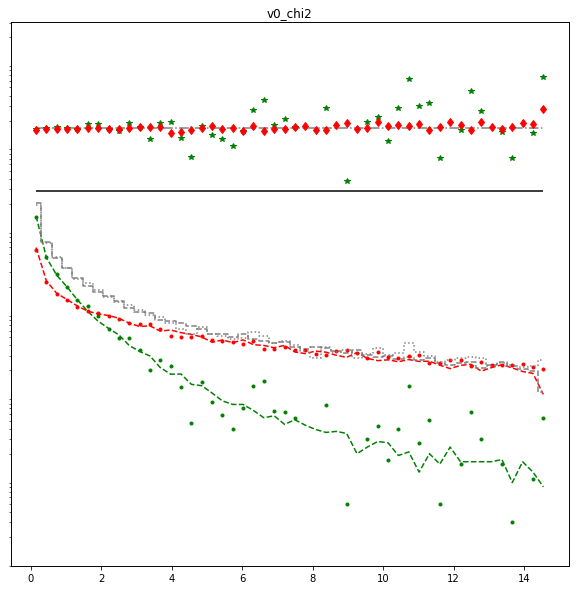

In [23]:
def plot_distribution(mc, data, feature, bins = 100, particle_type = 'Ks',ax=None,alpha=1,i=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,10))
    ax.set_yscale('log')
    
    q = (0.01,0.99)
    mc = mc[mask(mc[feature],np.quantile(mc[feature],q=q))]
    data = data[mask(data[feature],np.quantile(data[feature],q=q))]
    
    N = sum(mask(data.v0_ks_mass,signal_range)) - N_bkgr
    
    if isinstance(feature,str):
        feat_mc = mc[feature]
        feat_data = data[feature]
    elif isinstance(feature,dict):
        feat_mc = feature['mc']
        feat_data = feature['data']
    else:
        print("Error with 'feature'")
        return
    
    bin_range = (min(feat_mc.min(),feat_data.min()),max(feat_mc.max(),feat_data.max()))
    mc_sig_labels = mc['true'+particle_type].astype(bool)
    
    mc_sig = feat_mc[mc_sig_labels].sample(N)
    mc_bkgr = feat_mc[~mc_sig_labels].sample(N)
    
    data_sig_band = feat_data[mask(data.v0_ks_mass,signal_range)].sample(N+N_bkgr)
    data_side_band = pd.concat([feat_data[mask(data.v0_ks_mass,side_band_r)].sample(N_bkgr//2),feat_data[mask(data.v0_ks_mass,side_band_l)].sample(N_bkgr//2)])
    data_bkgr = feat_data[(data.v0_ks_mass > side_band_r[0])|(data.v0_ks_mass < side_band_l[1])].sample(N)
    
    mc_sig_vals, mc_sig_binc = hist(mc_sig,bins=bins,bin_range=bin_range)
    mc_bkgr_vals, mc_bkgr_binc = hist(mc_bkgr,bins=bins,bin_range=bin_range)
    mc_vals, mc_binc = hist(pd.concat([mc_sig,mc_bkgr]),bins=bins,bin_range=bin_range)
    
    data_sig_band_vals, data_sig_band_binc = hist(data_sig_band,bins=bins,bin_range=bin_range)
    data_side_band_vals, data_side_band_binc = hist(data_side_band,bins=bins,bin_range=bin_range)
    
    data_sig_vals, data_sig_binc = data_sig_band_vals - data_side_band_vals, data_sig_band_binc
    
    data_bkgr_vals, data_bkgr_binc = hist(data_bkgr,bins=bins,bin_range=bin_range)
#     data_vals, data_binc = hist(pd.concat([data_sig,data_bkgr]),bins=bins,bin_range=bin_range)
    
    ax.plot(mc_sig_binc,mc_sig_vals,'g',ls='dashed',alpha=alpha,label='MC signal')
    ax.plot(mc_bkgr_binc,mc_bkgr_vals,'r',ls='dashed',alpha=alpha,label='MC background')
    ax.step(mc_binc,mc_vals,ls='dashed',c='grey',where='mid',label='MC')
    
    ax.plot(data_sig_binc,data_sig_vals,'g.',alpha=alpha,label='Data signal')#,ls='dotted',alpha=0.5)
    ax.plot(data_bkgr_binc,data_bkgr_vals,'r.',alpha=alpha,label='Data background')#,ls='dotted',alpha=0.5)
    ax.step(data_sig_binc,data_sig_vals + data_bkgr_vals,ls='dotted',c='grey',where='mid',label='data')
    
    ax.set(ylim=(0.9,150*max((data_sig_vals + data_bkgr_vals).max(),mc_vals.max())),
          title=feature)
    
#     ax_res = plt.axes((0.1,-0.13,0.85,0.25))
    ax_res = ax.twinx()
    ax_res.set(ylim=(1e-7,5e1))
    ax_res.set_yscale('log')
    
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax_res.set_yticks([])
    ax_res.set_yticklabels([])
#     ax_res.set_yticks([1e1,1,1e-1])

    
    frac_sig = data_sig_vals/mc_sig_vals
    frac_bkgr = data_bkgr_vals/mc_bkgr_vals
    
    ax_res.plot(data_sig_binc[frac_sig>=1e-1],frac_sig[frac_sig>=1e-1],'g*',marker='*',alpha=alpha,label='signal data/mc ratio')
    ax_res.plot(data_bkgr_binc[frac_bkgr>=1e-1],frac_bkgr[frac_bkgr>=1e-1],'rd',marker='d',alpha=alpha,label='background data/mc ratio')
    ax_res.hlines(1,min(data_sig_binc),max(data_sig_binc),ls='dashdot',color='grey')
    ax_res.hlines(1e-1,min(data_sig_binc),max(data_sig_binc),color='k')
    
    if i==2:
        ax_res.legend(loc=3,framealpha=0.1)
        ax.legend(loc=4,framealpha=0.1)
    

plot_distribution(mc,data,'v0_chi2',bins=50)

C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater_equal


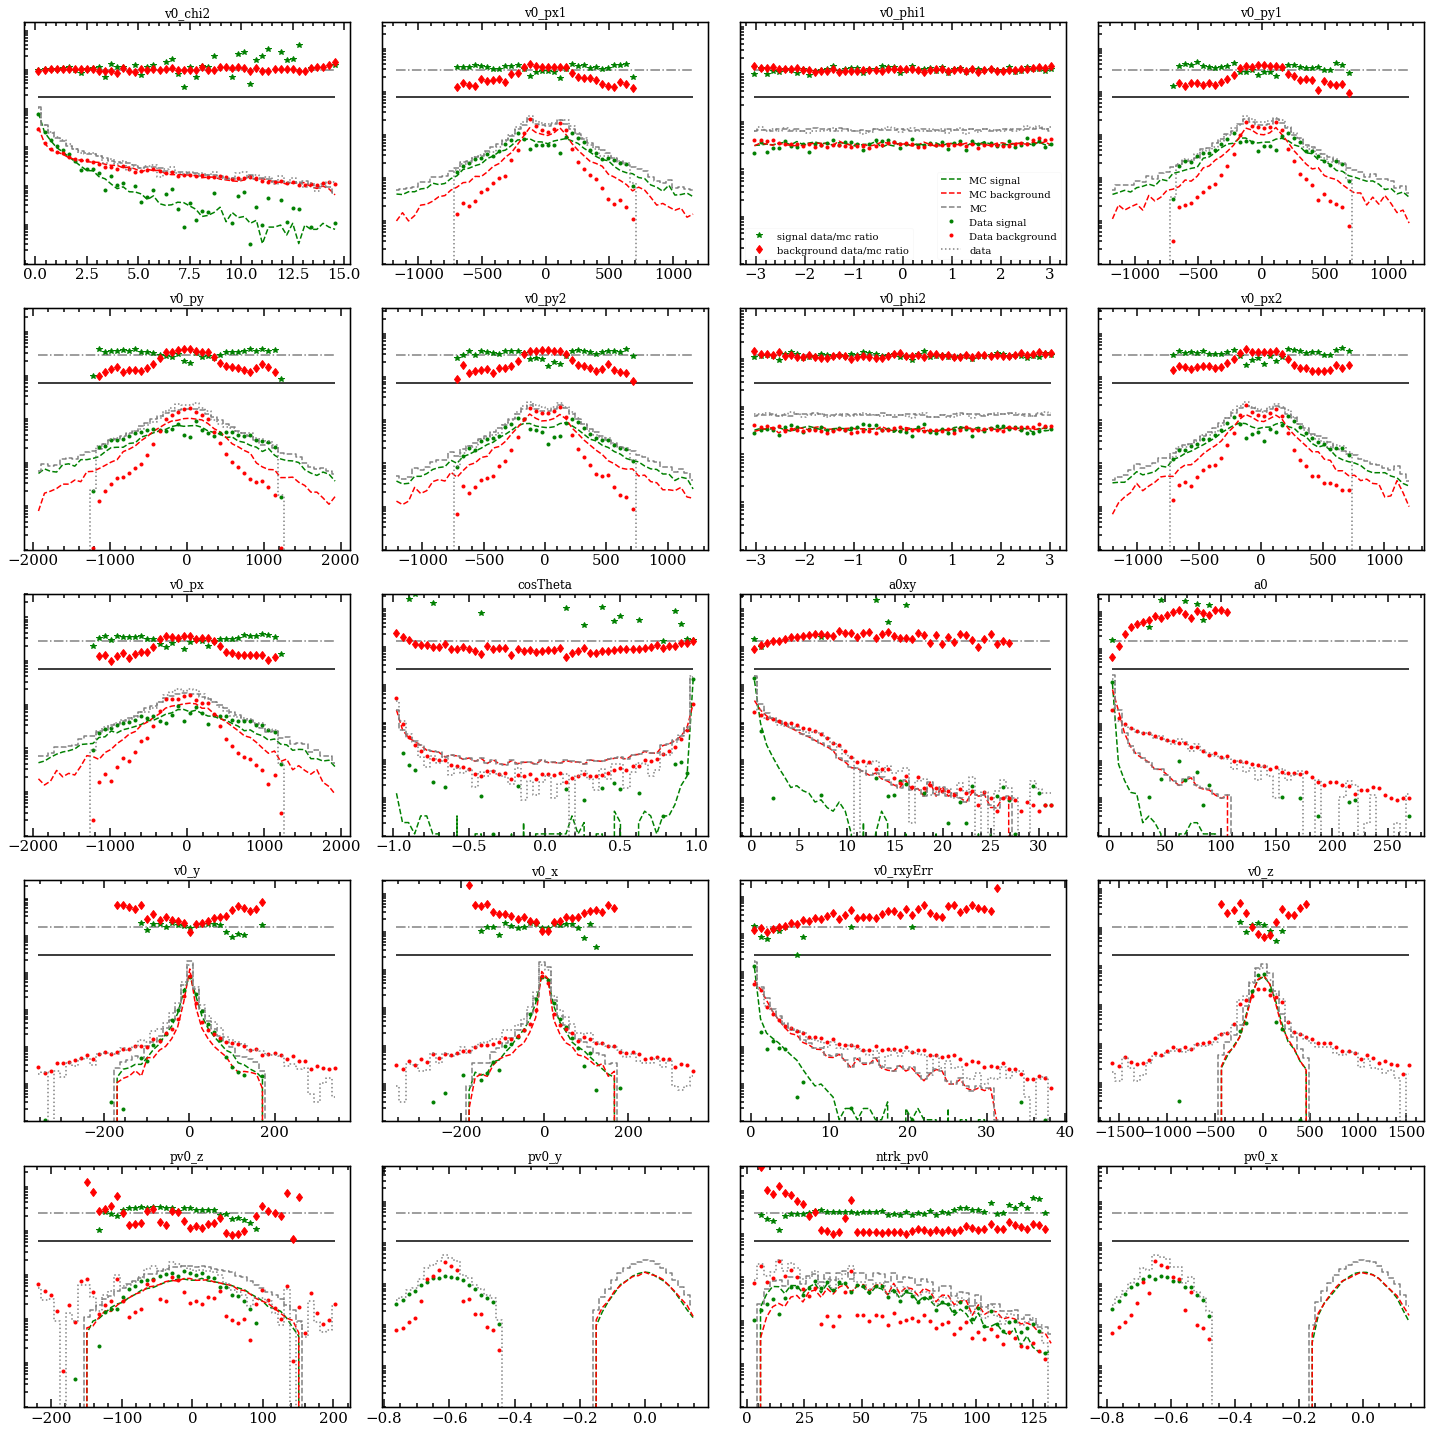

In [132]:
feats = "v0_chi2 v0_px1 v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 v0_px2 v0_px cosTheta a0xy a0 v0_y v0_x v0_rxyErr v0_z pv0_z pv0_y ntrk_pv0 pv0_x".split(" ")

fig, ax = plt.subplots(figsize=(20,20),ncols=4,nrows=5)
ax = ax.flatten()

for i, feat in enumerate(feats):
    plot_distribution(mc,data,feat,bins=50,ax=ax[i],i=i)
fig.tight_layout()

In [133]:
fig.savefig('distributions_mc_data.png')